In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math

2023-12-06 02:34:47.303223: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 02:34:47.340535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file = "../train.tsv"
test_file = "../test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:, 0:1] * 2.7 / 4   #季節を正規化
train_data2[:,2:3] = train_data2[:, 2:3] * 1.8 / 12 #月を正規化
train_data2[:,3:4] = train_data2[:, 3:4] * 62.3 / 23 #時間を正規化
train_data2[:,5:6] = train_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
train_data2[:,7:8] = train_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
train_data2[:,4:5] = train_data2[:, 4:5] * 0.2
train_data2[:,6:7] = train_data2[:, 6:7] * 5.6
train_data2[:,8:9] = train_data2[:, 8:9] * 9.5
train_data2[:,9:10] = train_data2[:, 9:10] * 8.9
train_data2[:,10:11] = train_data2[:, 10:11] * 3.4
train_data2[:,11:12] = train_data2[:, 11:12] * 1.5

train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,0:1] = test_data2[:, 0:1] * 2.7 / 4   #季節を正規化
test_data2[:,2:3] = test_data2[:, 2:3] * 1.8 / 12 #月を正規化
test_data2[:,3:4] = test_data2[:, 3:4] * 62.3 / 23 #時間を正規化
test_data2[:,5:6] = test_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
test_data2[:,7:8] = test_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
test_data2[:,4:5] = test_data2[:, 4:5] * 0.2
test_data2[:,6:7] = test_data2[:, 6:7] * 5.6
test_data2[:,8:9] = test_data2[:, 8:9] * 9.5
test_data2[:,9:10] = test_data2[:, 9:10] * 8.9
test_data2[:,10:11] = test_data2[:, 10:11] * 3.4
test_data2[:,11:12] = test_data2[:, 11:12] * 1.5
test_data2 = test_data2#.astype(np.float32)

#display(train_data2)
#display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1], 1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)
z = test_data2[:, :12]
z = z.reshape(z.shape[0], z.shape[1], 1)



In [3]:
osaka_file = "../test_local_osaka3.tsv"
osaka_data = pandas.read_csv(osaka_file, delimiter='\t').to_numpy()
osaka_data2 = np.empty((osaka_data.shape[0], osaka_data.shape[1]-2))
osaka_data2[:, 0:] = osaka_data[:, 2:]
osaka_data2[:,0:1] = osaka_data2[:, 0:1] * 2.7 / 4   #季節を正規化
osaka_data2[:,2:3] = osaka_data2[:, 2:3] * 1.8 / 12 #月を正規化
osaka_data2[:,3:4] = osaka_data2[:, 3:4] * 62.3 / 23 #時間を正規化
osaka_data2[:,5:6] = osaka_data2[:, 5:6] * 1.4 / 6.0   #曜日を正規化
osaka_data2[:,7:8] = osaka_data2[:, 7:8] * 2.2 / 4.0   #天気を正規化
osaka_data2[:,4:5] = osaka_data2[:, 4:5] * 0.2
osaka_data2[:,6:7] = osaka_data2[:, 6:7] * 5.6
osaka_data2[:,8:9] = osaka_data2[:, 8:9] * 9.5
osaka_data2[:,9:10] = osaka_data2[:, 9:10] * 8.9
osaka_data2[:,10:11] = osaka_data2[:, 10:11] * 3.4
osaka_data2[:,11:12] = osaka_data2[:, 11:12] * 1.5
osaka_data2 = osaka_data2.astype(np.float32)
osaka_y = osaka_data2.reshape(osaka_data2.shape[0], osaka_data2.shape[1], 1)
#display(osaka_data2)

In [4]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 1024  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加 #増やした

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

2023-12-06 02:34:50.506342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 02:34:50.529128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 02:34:50.529165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 02:34:50.532367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 02:34:50.532399: I tensorflow/compile

In [5]:
#def build_model(hp):
#  import keras
#  model = keras.Sequential()
#  model.add(keras.layers.Dense(
#      hp.Choice('units', [8, 16, 32]),
#      activation='relu'))
#  model.add(keras.layers.Dense(1, activation='relu'))
#  model.compile(loss='mse')
#  return model

#tuner = kt.RandomSearch(
#    build_model,
#    objective='val_loss',
#    max_trials=5)

#tuner.search(train_data2, epochs=5, validation_data=(train_data2))
#best_model = tuner.get_best_models()[0]

In [6]:
ES = EarlyStopping(mode='auto', patience=128)
model.fit(y, x,
          batch_size=16, #デフォは32
          epochs=512, #512epochで学習
          validation_split=0.01, #学習データの5%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/512


2023-12-06 02:34:54.442281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-12-06 02:34:55.198199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-06 02:34:55.228013: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f968c14ef00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 02:34:55.228050: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-06 02:34:55.234125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 02:34:55.320744: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

535/535 [==============================] - 6s 6ms/step - loss: 17477.8105 - accuracy: 0.0123 - val_loss: 11051.7021 - val_accuracy: 0.0115
Epoch 2/512
535/535 [==============================] - 3s 5ms/step - loss: 11553.5264 - accuracy: 0.0125 - val_loss: 7772.9116 - val_accuracy: 0.0115
Epoch 3/512
535/535 [==============================] - 3s 5ms/step - loss: 10439.1787 - accuracy: 0.0126 - val_loss: 7815.2090 - val_accuracy: 0.0115
Epoch 4/512
535/535 [==============================] - 3s 5ms/step - loss: 9749.1699 - accuracy: 0.0126 - val_loss: 6129.3311 - val_accuracy: 0.0115
Epoch 5/512
535/535 [==============================] - 3s 5ms/step - loss: 8928.1807 - accuracy: 0.0124 - val_loss: 5086.9937 - val_accuracy: 0.0115
Epoch 6/512
535/535 [==============================] - 3s 5ms/step - loss: 7545.9805 - accuracy: 0.0126 - val_loss: 3998.2471 - val_accuracy: 0.0115
Epoch 7/512
535/535 [==============================] - 3s 5ms/step - loss: 5354.3589 - accuracy: 0.0126 - val_loss

In [7]:
predicted = model.predict(y,batch_size=32)
model.evaluate(y,x,batch_size=32)

187/271 [===================>..........] - ETA: 0s

271/271 [==============================] - 1s 3ms/step - loss: 148.5725 - accuracy: 0.0125


[148.57249450683594, 0.012492770329117775]

In [8]:
def check(i):
    import math
    if i< 0:
        return 0
    else:
        return math.floor(i)

In [9]:
checked = np.array([check(i) for i in predicted]).reshape(predicted.shape[0],1)
r2 = 1 -  np.sum((checked - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.9916811490917611


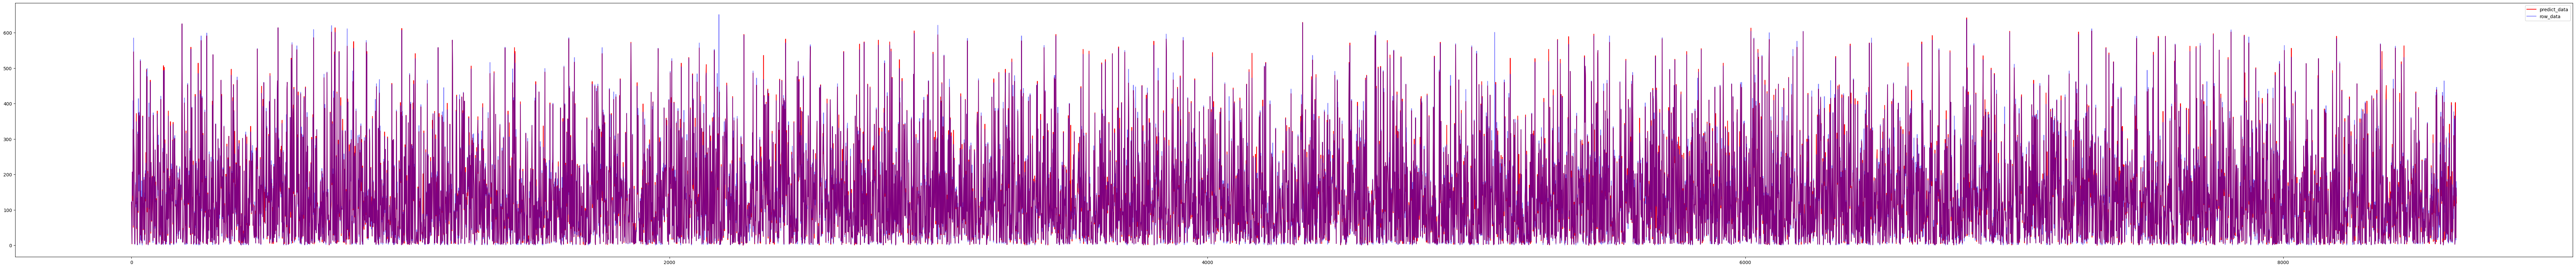

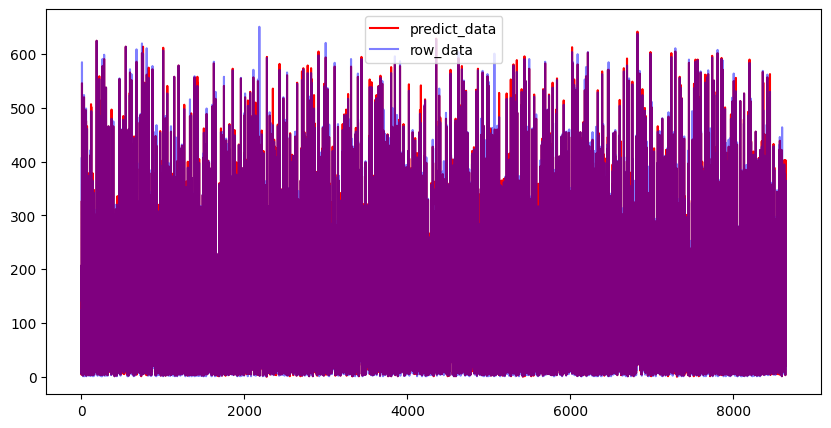

In [10]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(checked)),checked, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(0,len(checked)),checked, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

273/273 [==============================] - 1s 2ms/step


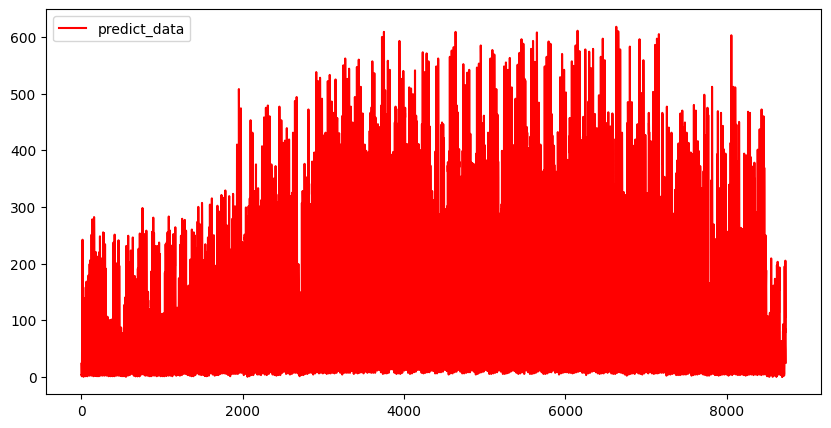

In [11]:
predictedz = model.predict(z,batch_size=32)
checkedz = np.array([check(i) for i in predictedz]).reshape(predictedz.shape[0],1)

plt.figure(figsize=(10,5))
plt.plot(range(0,len(checkedz)),checkedz, color="r", label="predict_data")
plt.legend()
plt.show()

274/274 [==============================] - 0s 2ms/step


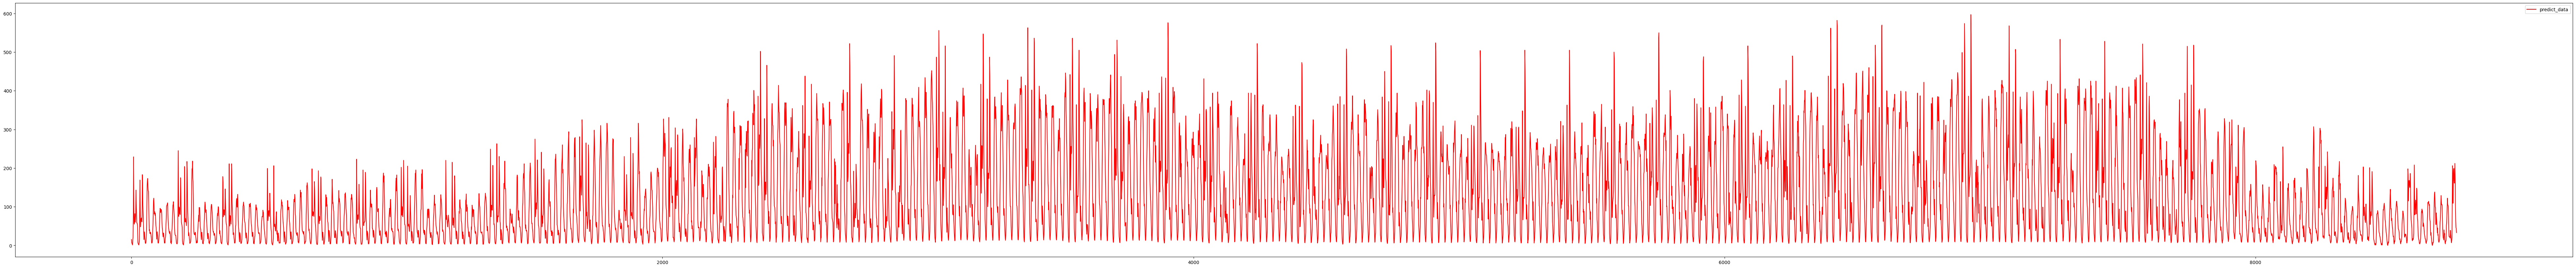

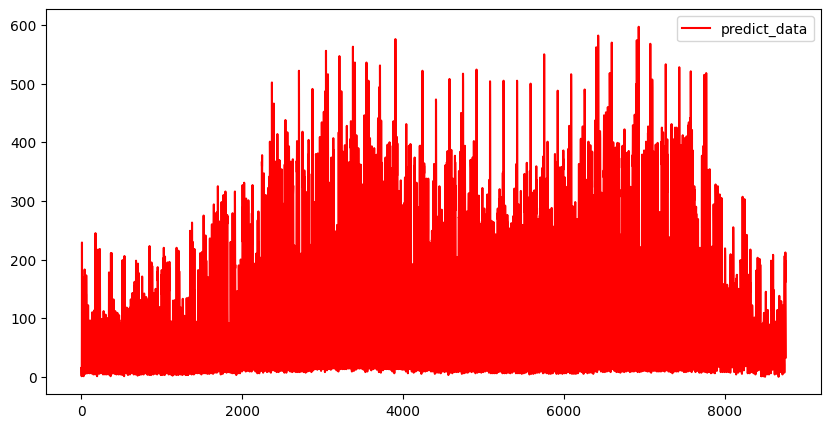

In [12]:
osaka_predicted = model.predict(osaka_y)
osaka_checked = np.array([check(i) for i in osaka_predicted]).reshape(osaka_predicted.shape[0],1)
plt.figure(figsize=(100,10))
plt.plot(range(0,len(osaka_checked)),osaka_checked, color="r", label="predict_data")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(0,len(osaka_checked)),osaka_checked, color="r", label="predict_data")
plt.legend()
plt.show()

In [13]:
osaka_data3 = np.hstack((osaka_data,osaka_checked))
np.savetxt(".tsvってなに？.csv",osaka_data3,delimiter=",",fmt="%s")